
#  Bike Sharing Predictions in Washington D.C.

### Leandro Handal Baracatt 
#### MSc Management | MSc Business Analytics & Big Data	
#### <lhandalb@gmail.com>
  

---

# Importing Packages and Libraries <a class="anchor" id="1"></a>

In [3]:
import s3fs
import numpy as np
import pandas as pd
from dask.distributed import Client
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from sklearn.externals import joblib
import matplotlib as plt
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline
from dask_ml.preprocessing import MinMaxScaler, DummyEncoder, StandardScaler
from scikitplot.metrics import plot_calibration_curve
from scikitplot.plotters import plot_learning_curve
from scikitplot.estimators import plot_feature_importances
from sklearn.linear_model import LinearRegression, Ridge
#from dask_ml.linear_model import LinearRegression
from dask_ml.xgboost import XGBRegressor
from dask_ml.metrics import accuracy_score
from dask_ml.datasets import make_regression
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from dask_ml.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import dask_searchcv as dcv
from vecstack import stacking
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import itertools
from pylab import rcParams
import statsmodels.api as sm
import sys

if not sys.warnoptions:
    import warnings

    warnings.simplefilter("ignore")

In [4]:
client = Client(n_workers=8, memory_limit='16GB')
client

Client Scheduler: tcp://127.0.0.1:57049,Cluster Workers: 8 Cores: 8 Memory: 128.00 GB


# Reading the Data<a class="anchor" id="2"></a>

In [5]:
day_url = "https://s3.us-east-2.amazonaws.com/leandrohandal/bike_share/day.csv"
hour_url = "https://s3.us-east-2.amazonaws.com/leandrohandal/bike_share/hour.csv"

In [6]:
day = dd.read_csv(day_url, parse_dates=["dteday"]).set_index('instant')
hour = dd.read_csv(hour_url, parse_dates=["dteday"]).set_index('instant')

In [7]:
day.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [8]:
hour.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [9]:
hour.dtypes

dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

   There are 0 null values in the Hour dataset.           There are 0 null values in the Day dataset.


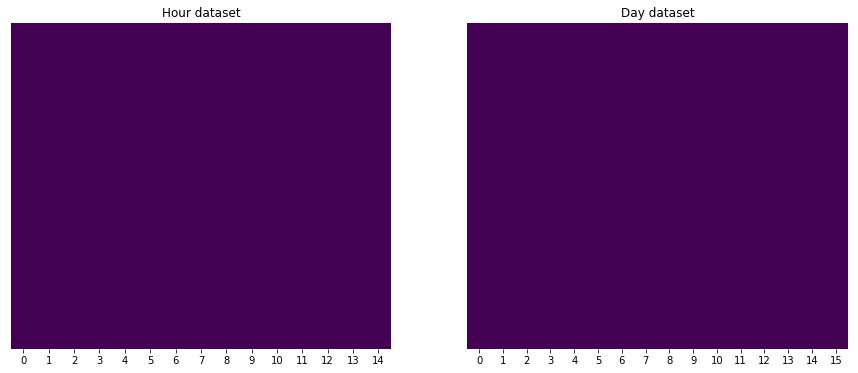

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
sns.heatmap(
    day.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax1
).set_title("Hour dataset")
sns.heatmap(
    hour.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax2
).set_title("Day dataset")

print(
    "   There are {} null values in the Hour dataset.           There are {} null values in the Day dataset.".format(
        hour.isnull().sum().sum().compute(), day.isnull().sum().sum().compute()
    )
)

# Exploratory Data Analysis<a class="anchor" id="3"></a>

## Variable Names and Encoding<a class="anchor" id="3.1"></a>

Before starting the EDA, we decided to make some adjustments to the column names and categorical values, in order to make them easier to read and understand.

In [11]:
day = day.rename(
    columns={
        "dteday": "datetime",
        "holiday": "is_holiday",
        "workingday": "is_workingday",
        "weathersit": "weather_condition",
        "hum": "humidity",
        "mnth": "month",
        "cnt": "total_count",
        "hr": "hour",
        "yr": "year",
    }
)


hour = hour.rename(
    columns={
        "dteday": "datetime",
        "holiday": "is_holiday",
        "workingday": "is_workingday",
        "weathersit": "weather_condition",
        "hum": "humidity",
        "mnth": "month",
        "cnt": "total_count",
        "hr": "hour",
        "yr": "year",
    }
)

In [12]:
hour["month"] = (
    hour["month"]
    .mask(hour["month"] == 1, "january")
    .mask(hour["month"] == 2, "february")
    .mask(hour["month"] == 3, "march")
    .mask(hour["month"] == 4, "april")
    .mask(hour["month"] == 5, "may")
    .mask(hour["month"] == 6, "june")
    .mask(hour["month"] == 7, "july")
    .mask(hour["month"] == 8, "august")
    .mask(hour["month"] == 9, "september")
    .mask(hour["month"] == 10, "october")
    .mask(hour["month"] == 11, "november")
    .mask(hour["month"] == 12, "decebmer")
)

hour["season"] = (
    hour["season"]
    .mask(hour["season"] == 1, "spring")
    .mask(hour["season"] == 2, "summer")
    .mask(hour["season"] == 3, "fall")
    .mask(hour["season"] == 4, "winter")
)

hour["year"] = (
    hour["year"]
    .mask(hour["year"] == 0, "2011")
    .mask(hour["year"] == 1, "2012")
)

hour["weekday"] = (
    hour["weekday"]
    .mask(hour["weekday"] == 1, "monday")
    .mask(hour["weekday"] == 2, "tuesday")
    .mask(hour["weekday"] == 3, "wednesday")
    .mask(hour["weekday"] == 4, "thursday")
    .mask(hour["weekday"] == 5, "friday")
    .mask(hour["weekday"] == 6, "saturday")
    .mask(hour["weekday"] == 0, "sunday")
)

hour["weather_condition"] = (
    hour["weather_condition"]
    .mask(hour["weather_condition"] == 1, "clear")
    .mask(hour["weather_condition"] == 2, "cloudy")
    .mask(hour["weather_condition"] == 3, "light_rain_snow")
    .mask(hour["weather_condition"] == 4, "heavy_rain_snow")
)

In [13]:
day["month"] = (
    day["month"]
    .mask(day["month"] == 1, "january")
    .mask(day["month"] == 2, "february")
    .mask(day["month"] == 3, "march")
    .mask(day["month"] == 4, "april")
    .mask(day["month"] == 5, "may")
    .mask(day["month"] == 6, "june")
    .mask(day["month"] == 7, "july")
    .mask(day["month"] == 8, "august")
    .mask(day["month"] == 9, "september")
    .mask(day["month"] == 10, "october")
    .mask(day["month"] == 11, "november")
    .mask(day["month"] == 12, "decebmer")
)

day["season"] = (
    day["season"]
    .mask(day["season"] == 1, "spring")
    .mask(day["season"] == 2, "summer")
    .mask(day["season"] == 3, "fall")
    .mask(day["season"] == 4, "winter")
)

day["year"] = (
    day["year"]
    .mask(day["year"] == 0, "2011")
    .mask(day["year"] == 1, "2012")
)

day["weekday"] = (
    day["weekday"]
    .mask(day["weekday"] == 1, "monday")
    .mask(day["weekday"] == 2, "tuesday")
    .mask(day["weekday"] == 3, "wednesday")
    .mask(day["weekday"] == 4, "thursday")
    .mask(day["weekday"] == 5, "friday")
    .mask(day["weekday"] == 6, "saturday")
    .mask(day["weekday"] == 0, "sunday")
)

day["weather_condition"] = (
    day["weather_condition"]
    .mask(day["weather_condition"] == 1, "clear")
    .mask(day["weather_condition"] == 2, "cloudy")
    .mask(day["weather_condition"] == 3, "light_rain_snow")
    .mask(day["weather_condition"] == 4, "heavy_rain_snow")
)

In [14]:
day.head()

,datetime,season,year,month,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
instant,,,,,,,,,,,,,,,
1,2011-01-01,spring,2011,january,0,saturday,0,cloudy,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,spring,2011,january,0,sunday,0,cloudy,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,spring,2011,january,0,monday,1,clear,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,spring,2011,january,0,tuesday,1,clear,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,spring,2011,january,0,wednesday,1,clear,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [15]:
hour.head()

,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
instant,,,,,,,,,,,,,,,,
1,2011-01-01,spring,2011,january,0,0,saturday,0,clear,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,spring,2011,january,1,0,saturday,0,clear,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,spring,2011,january,2,0,saturday,0,clear,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,spring,2011,january,3,0,saturday,0,clear,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,spring,2011,january,4,0,saturday,0,clear,0.24,0.2879,0.75,0.0,0,1,1


Please take some time to appreciate how we color-coded all variables to match among plots and used appropriate colors to easily identify them! 😉

## Frequencies<a class="anchor" id="3.2"></a>

The following bar graph shows the count of bikes rented per season for the years 2011 and 2012. By doing so, we get a clear overview of how the target variable distributed over time.

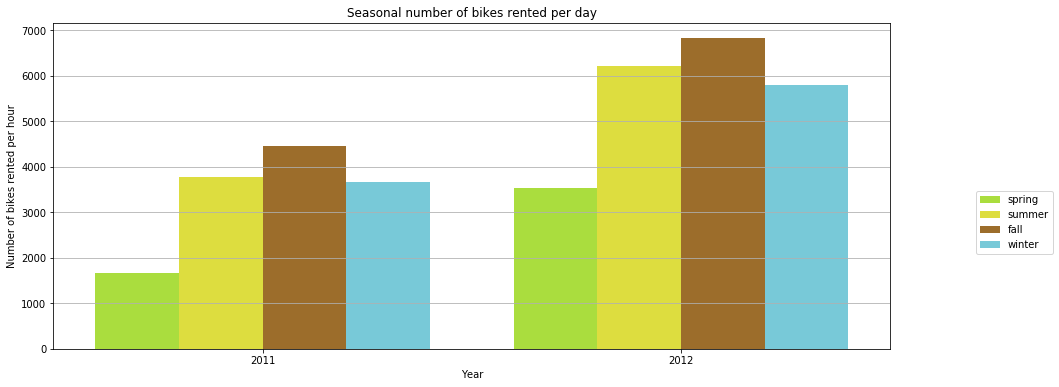

In [16]:
plt.figure(figsize=(15, 6))
sns.barplot(
    "year",
    "total_count",
    hue="season",
    data=day.compute(),
    palette=["#b4f724", "#f7f725", "#af7018", "#68d4e8"],
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Year")
plt.ylabel("Number of bikes rented per hour")
plt.title("Seasonal number of bikes rented per day")
plt.xticks(ticks=(0, 1), labels=("2011", "2012"))
plt.grid(which="major", axis="y")

* There was a substantial increase in bike renting from year 2011 to year 2012.
* However, the trend for number of bikes rented based on seasons is the same each year.
* Bikes are least rented in Spring and the most during Fall.
* After Spring, there is a sudden increase in bike renting during summer.

After looking at the differences per season, we zoom into each season and month to see what the drivers are for bike renting in terms of weather and type of day in the week. This done by multiple bar grahps.

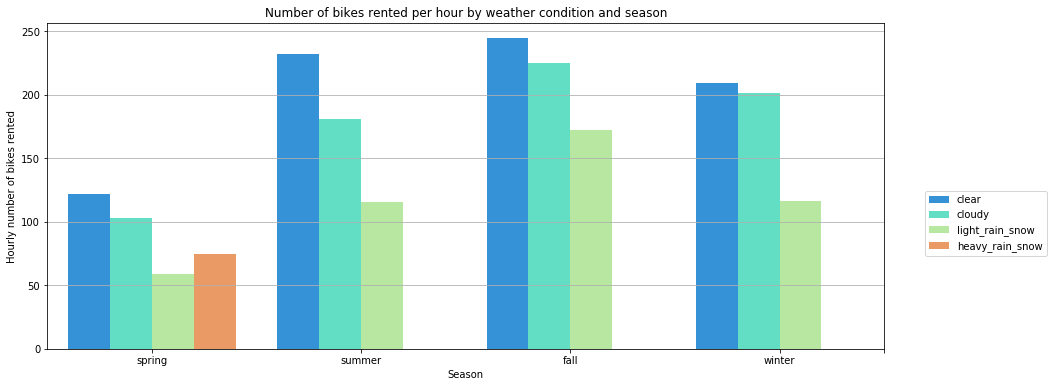

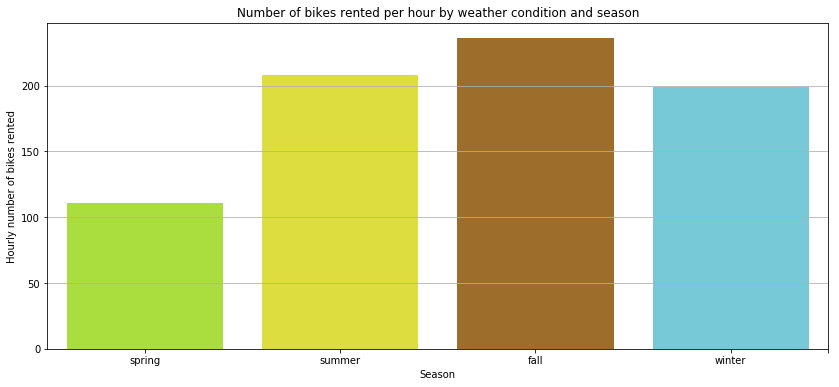

In [17]:
plt.figure(figsize=(15, 6))
sns.barplot(
    "season",
    "total_count",
    hue="weather_condition",
    data=hour.compute(),
    palette="rainbow",
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Season")
plt.ylabel("Hourly number of bikes rented")
plt.title("Number of bikes rented per hour by weather condition and season")
plt.xticks(ticks=(0, 1, 2, 3, 3.5))
plt.grid(which="major", axis="y")

plt.figure(figsize=(14, 6))
sns.barplot(
    "season",
    "total_count",
    data=hour.compute(),
    palette=["#b4f724", "#f7f725", "#af7018", "#68d4e8"],
    ci=None,
)
plt.xlabel("Season")
plt.ylabel("Hourly number of bikes rented")
plt.title("Number of bikes rented per hour by weather condition and season")
plt.xticks(ticks=(0, 1, 2, 3, 3.5))
plt.grid(which="major", axis="y")

Text(0.5, 179.46308763450142, 'Average')

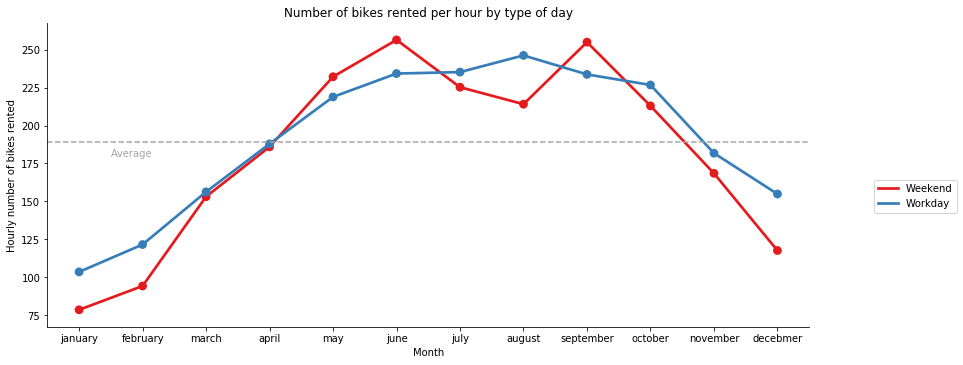

In [18]:
sns.catplot(
    x="month",
    y="total_count",
    kind="point",
    hue="is_workingday",
    data=hour.compute(),
    ci=None,
    palette="Set1",
    aspect=2.3,
    legend=False,
)
plt.legend(("Weekend", "Workday"), loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Month")
plt.ylabel("Hourly number of bikes rented")
plt.title("Number of bikes rented per hour by type of day")
plt.axhline(hour.total_count.mean().compute(), ls="--", color="#a5a5a5")
plt.text(0.5, hour.total_count.mean().compute() - 10, "Average", color="#a5a5a5")

Text(0.5, 159.46308763450142, 'Average')

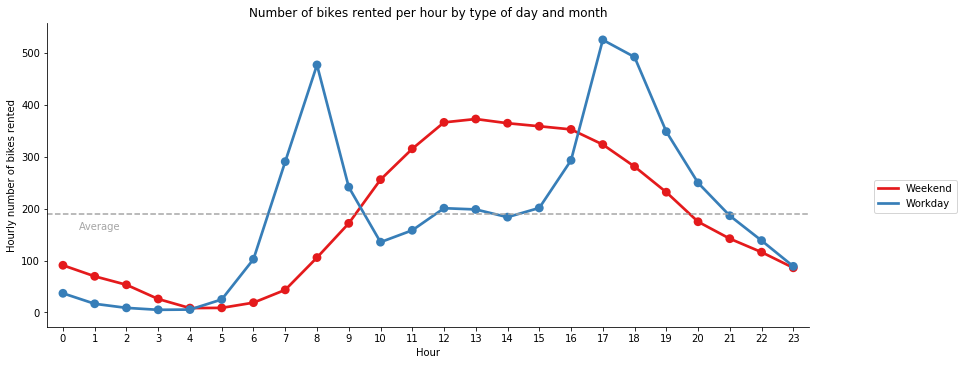

In [19]:
sns.catplot(
    x="hour",
    y="total_count",
    kind="point",
    hue="is_workingday",
    data=hour.compute(),
    ci=None,
    palette="Set1",
    aspect=2.3,
    legend=False,
)
plt.legend(("Weekend", "Workday"), loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Hour")
plt.ylabel("Hourly number of bikes rented")
plt.title("Number of bikes rented per hour by type of day and month")
plt.axhline(hour.total_count.mean().compute(), ls="--", color="#a5a5a5")
plt.text(0.5, hour.total_count.mean().compute() - 30, "Average", color="#a5a5a5")

## Boxplots (Outliers)<a class="anchor" id="3.3"></a>

Box plots are useful for getting an idea of the distribution of numerical features and detect potential outliers. Therefore, we use different box plots to see the different distributions of `total_count`, `casual` and `registrered`. It is clear that each variable has outliers, we deal with them in the Chapter Preprocessing.

Text(0.5, 1.0, 'Boxplots of count variables')

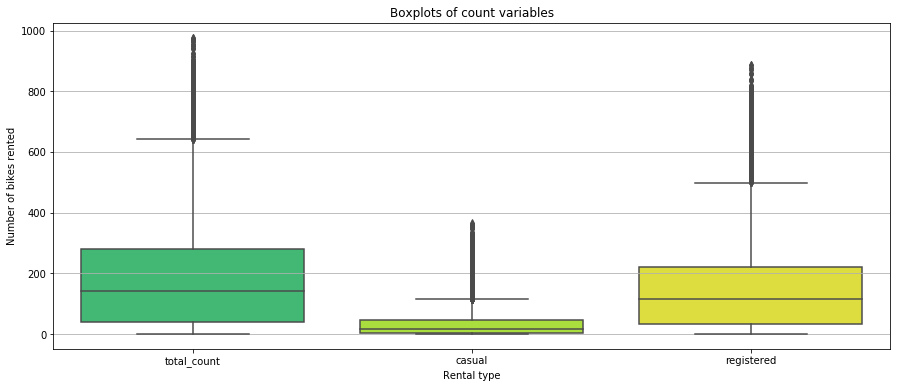

In [20]:
plt.subplots(figsize=(15, 6))
sns.boxplot(
    data=hour[["total_count", "casual", "registered"]].compute(),
    palette=["#2ecc71", "#b4f724", "#f7f725"],
)
plt.grid(which="major", axis="y")
plt.xlabel("Rental type")
plt.ylabel("Number of bikes rented")
plt.title("Boxplots of count variables")

Additionally, we created box plot for the weather variables with the same purpose of the previous ones.

Text(0.5, 1.0, 'Boxplots of weather variables')

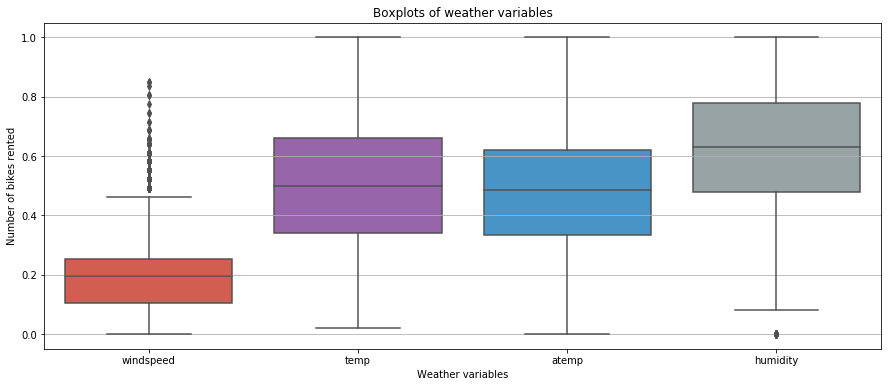

In [21]:
plt.subplots(figsize=(15, 6))
sns.boxplot(
    data=hour[["windspeed", "temp", "atemp", "humidity"]].compute(),
    palette=["#e74c3c", "#9b59b6", "#3498db", "#95a5a6"],
)
plt.grid(which="major", axis="y")
plt.xlabel("Weather variables")
plt.ylabel("Number of bikes rented")
plt.title("Boxplots of weather variables")

## Relationships Between Variables<a class="anchor" id="3.4"></a>

Another important step in the EDA, before feature engineering, is to see what the relationship is between potential predicting variables and the target variable. This gives us an idea of what features might be important for including in the model.

Text(0.5, 1.0, 'Correlations of variables with target variable')

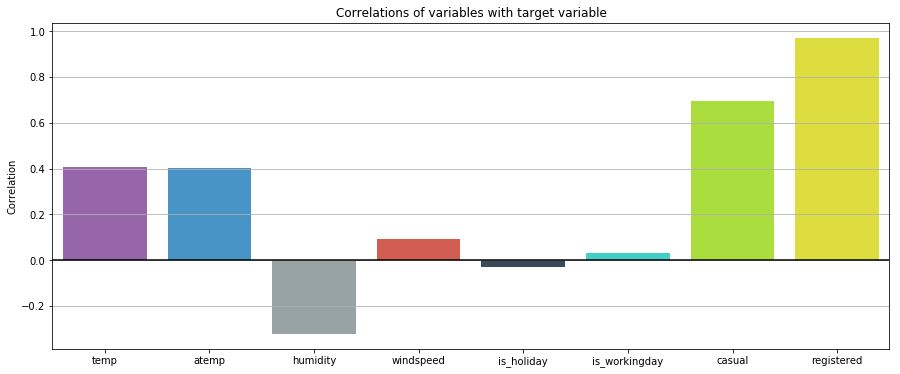

In [22]:
plt.subplots(figsize=(15, 6))
corr = hour[
    [
        "temp",
        "atemp",
        "humidity",
        "windspeed",
        "is_holiday",
        "is_workingday",
        "casual",
        "registered",
    ]
].compute().corrwith(hour["total_count"].compute())
sns.barplot(
    x=corr.index,
    y=corr,
    palette=[
        "#9b59b6",
        "#3498db",
        "#95a5a6",
        "#e74c3c",
        "#34495e",
        "#2be5dc",
        "#b4f724",
        "#f7f725",
    ],
)
plt.axhline(-0, 0, color="black")
plt.grid(which="major", axis="y")
plt.ylabel("Correlation")
plt.title("Correlations of variables with target variable")

We can conclude that casual and registered bike rents are strongly correlated with the `total_count`, which makes sense because together they make up for the target variable. Other strongly correlated variables are `temp` and `atemp`.

Text(0.5, 1.0, 'Correlation Matrix')

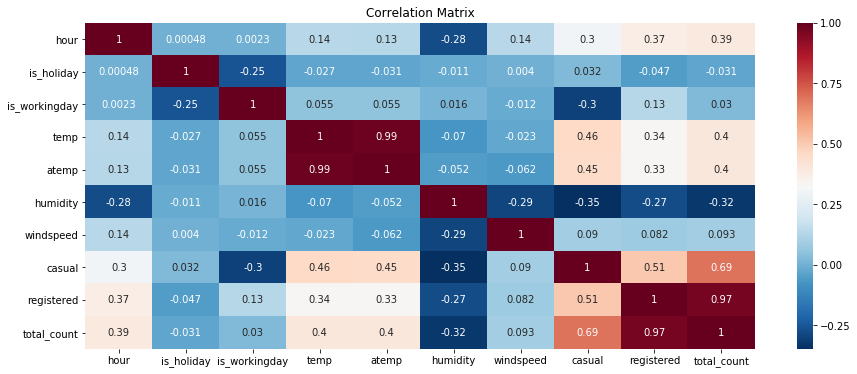

In [23]:
plt.figure(figsize=(15, 6))
sns.heatmap(hour.corr().compute(), cmap="RdBu_r", vmax=1, annot=True)
plt.title("Correlation Matrix")

Clearly, from above heatmap, we can se that the dataset has multicolinearity. `temp` and `atemp` are highly correlated.
Will need to drop one of them.

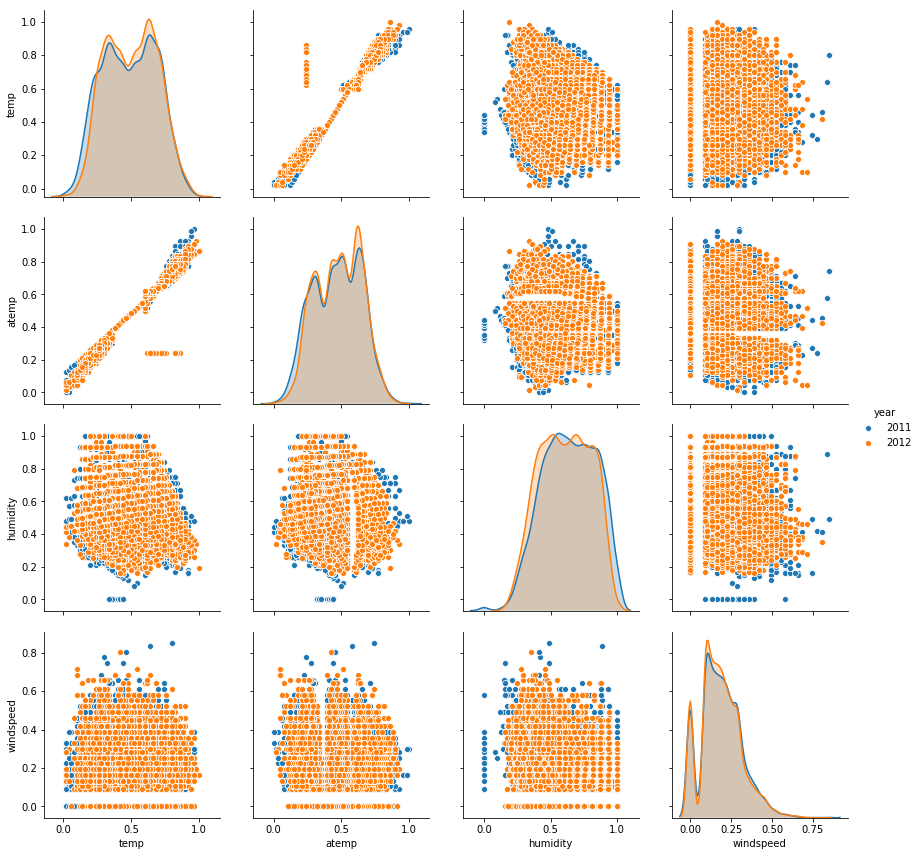

In [24]:
# Visualize the relationship among all continous variables using pairplots
NumericFeatureList = ["temp", "atemp", "humidity", "windspeed"]
sns.pairplot(hour.compute(), hue="year", vars=NumericFeatureList, height=3)

As we can see looking at the EDA and inspecting the datasets, the `hour` dataset holds the same information than `day` and with a lot more detail. Therefore we have decided to continue the analysis using onlt `hour` as our data.

# Feature Engineering<a class="anchor" id="4"></a>

## Variable Creation<a class="anchor" id="4.1"></a>

### Average Activity<a class="anchor" id="4.1.1"></a>

As seen in the EDA, rentals increase and decrease depending on the time of the day. Hence, we decided to bin the `hour` variable into three categories: `sleep_hours`, `work_hours` and `free_hours`.

According to a study made by Fortune.com, the average hours where citizens of Washington D.C. are asleep are from 11:30pm to 7:20am.

For `sleep_hours` we stretched that range a little more on the lower side because we think that even if people are not asleep per se, they might be home already since 9:00pm.

As for `work_hours` we used the regular work schedule in the US, consisting of 8 hours, from 9:00 to 17:00 during the working days.

And lastly `free_hours` consists of anything in between the last two during working days and everything but `sleep_hours` during the weekends.

_Source: http://fortune.com/2015/07/07/cities-sleep-patterns-health/_

In [25]:
shape = (len(hour), len(hour.columns))

In [26]:
sleep_hours = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6]
work_hours = [9, 10, 11, 12, 13, 14, 15, 16]
free_hours = [7, 8, 17, 18, 19, 20]

In [27]:
average_activity = dd.from_dask_array(da.zeros((shape[0], 1)), columns=['average_activity'], index=hour.index)

In [28]:
condition_sleep = (hour['hour'].isin(sleep_hours))
condition_work = (hour['hour'].isin(work_hours)) & (hour['is_workingday'] == 1)
condition_free1 = (hour['hour'].isin(work_hours)) & (hour['is_workingday'] == 0)
condition_free2 = (hour['hour'].isin(free_hours))

In [29]:
average_activity['average_activity'] = average_activity['average_activity'].mask(condition_sleep, 'sleep_hours')
average_activity['average_activity'] = average_activity['average_activity'].mask(condition_work, 'work_hours')
average_activity['average_activity'] = average_activity['average_activity'].mask(condition_free1, 'free_hours')
average_activity['average_activity'] = average_activity['average_activity'].mask(condition_free2, 'free_hours')

In [30]:
hour['average_activity'] = average_activity['average_activity']

### Commute Schedule<a class="anchor" id="4.1.2"></a>

We realized that during working days, most people could use the bike rentals to commute to work, therefore we created a new variable `is_commute`.

We took into consideration the rush commute hours in Washington D.C. accordint to a study by TripSavvy.com where they explain that the most common commute times in the city are from 6 a.m. to 9:30 a.m. and 3:30 p.m. to 6:30 p.m.

We used these timeframes to create the new variable taking into account the day of the week as well, since rush hour happens mostly from Monday to Friday.

_Source: https://www.tripsavvy.com/driving-times-from-dc-1040439_

In [31]:
commute_hours = [6, 7, 8, 9, 15, 16, 17, 18]

In [32]:
is_commute = dd.from_dask_array(da.zeros((shape[0], 1)), columns=['is_commute'], index=hour.index)

In [33]:
condition_commute = (hour['hour'].isin(commute_hours))

In [34]:
is_commute['is_commute'] = is_commute['is_commute'].mask(condition_commute, '1')

In [35]:
hour['is_commute'] = is_commute['is_commute']

---

# Preprocessing<a class="anchor" id="5"></a>

## Scaling and Normalizing<a class="anchor" id="5.1"></a>

We will rescale variables `registered` and `casual` just in case we decide to include them in the analysis later on.

In [36]:
hour['registered'] -= hour['registered'].min()
hour['registered'] /= hour['registered'].max()

hour['casual'] -= hour['casual'].min()
hour['casual'] /= hour['casual'].max()

## Handling Outliers<a class="anchor" id="5.2"></a>

Even though, `windspeed` and `humidity` have been normalized prior to the data ingestion, if data contains outliers, scaling using the mean and variance of the data is likely to not work very well. In these cases,it is better to use `robust_scale` and `RobustScaler` as drop-in replacements instead. They use more robust estimates for the center and range of the data.

In [37]:
# This didn't work :(

# hour.windspeed = robust_scale(hour.windspeed, axis=0)
# hour.humidity = robust_scale(hour.humidity, axis=0);

### Clipping Outliers<a class="anchor" id="5.2.1"></a>

Since the outliers remain after the normalization, we can now proceed if it is viable to remove them or just clip them to any range of interquartiles.

Text(0.5, 1.0, 'Boxplots of weather variables')

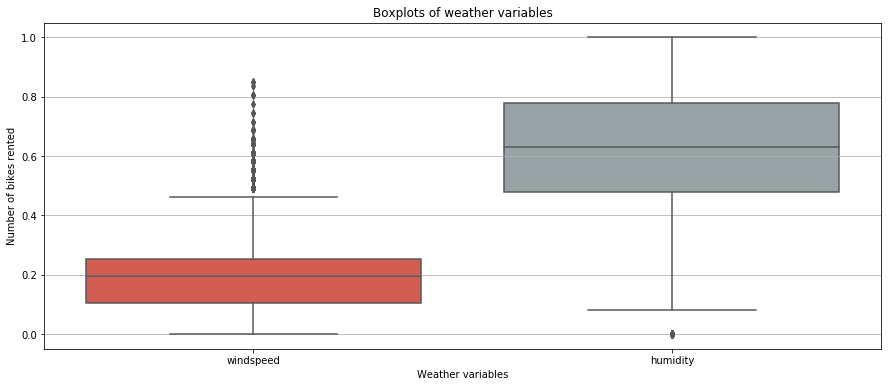

In [38]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=hour[["windspeed", "humidity"]].compute(), palette=["#e74c3c", "#95a5a6"])
plt.grid(which="major", axis="y")
plt.xlabel("Weather variables")
plt.ylabel("Number of bikes rented")
plt.title("Boxplots of weather variables")

[]

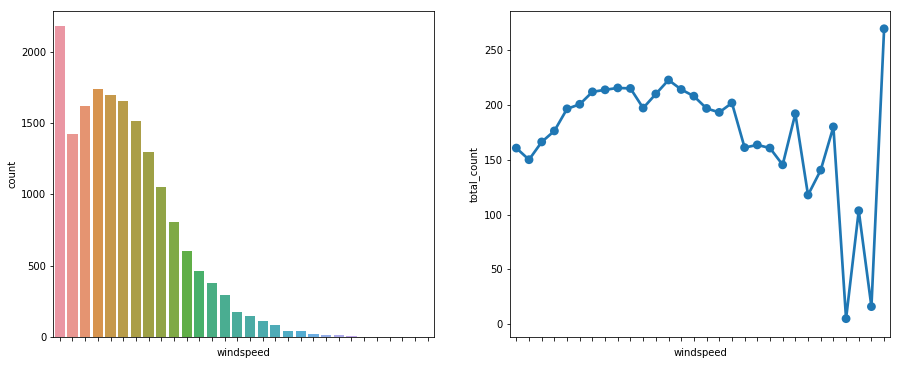

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(hour['windspeed'].compute(), ax=ax1)
sns.pointplot(x="windspeed", y="total_count", data=hour.compute(), ci=None, ax=ax2)
ax1.set_xticklabels('')
ax2.set_xticklabels('')

As we can see above, the outliers do seem to skew the data a little bit, and the percentage of rows that contain outliers seems to be small enough to remove them safely. We now proceed to remove those outliers. We will first try to clip them to the .98 IQR for `windspeed` and to the 0.01 IQR for `humidity` since they seem to the thresholds to remove the outliers.

In [40]:
windspeed = dd.from_dask_array(da.zeros((shape[0], 1)), columns=['windspeed'], index=hour.index)

In [41]:
condition_windspeed_high = (hour['windspeed'] > hour['windspeed'].quantile(0.98))
condition_windspeed_leave = ((hour['windspeed'] < hour['windspeed'].quantile(0.98)) & (hour['windspeed'] > hour['windspeed'].quantile(0.01)))
condition_windspeed_low = (hour['windspeed'] < hour['windspeed'].quantile(0.01))

In [42]:
windspeed['windspeed'] = windspeed['windspeed'].mask(condition_windspeed_high, hour['windspeed'].quantile(0.98))
windspeed['windspeed'] = windspeed['windspeed'].mask(condition_windspeed_leave, hour['windspeed'])
windspeed['windspeed'] = windspeed['windspeed'].mask(condition_windspeed_low, hour['windspeed'].quantile(0.01))

In [43]:
hour['windspeed'] = windspeed['windspeed']

In [44]:
humidity = dd.from_dask_array(da.zeros((shape[0], 1)), columns=['humidity'], index=hour.index)

In [45]:
condition_humidity_leave = (hour['humidity'] > hour['humidity'].quantile(0.01))
condition_humidity_low = (hour['humidity'] < hour['humidity'].quantile(0.01))

In [46]:
humidity['humidity'] = humidity['humidity'].mask(condition_humidity_low, hour['humidity'].quantile(0.01))
humidity['humidity'] = humidity['humidity'].mask(condition_humidity_leave, hour['humidity'])

In [47]:
hour['humidity'] = humidity['humidity']

Text(0.5, 1.0, 'Boxplots of weather variables')

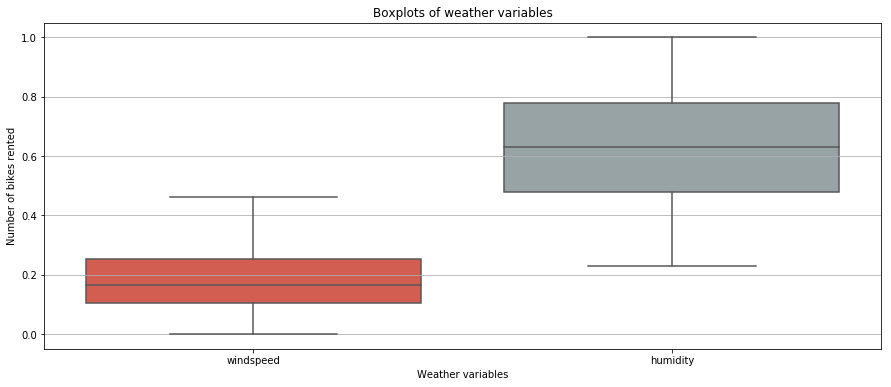

In [48]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=hour[["windspeed", "humidity"]].compute(), palette=["#e74c3c", "#95a5a6"])
plt.grid(which="major", axis="y")
plt.xlabel("Weather variables")
plt.ylabel("Number of bikes rented")
plt.title("Boxplots of weather variables")

Now the outliers have been removed by forcing their values inside the respective IQR for each variable.

[]

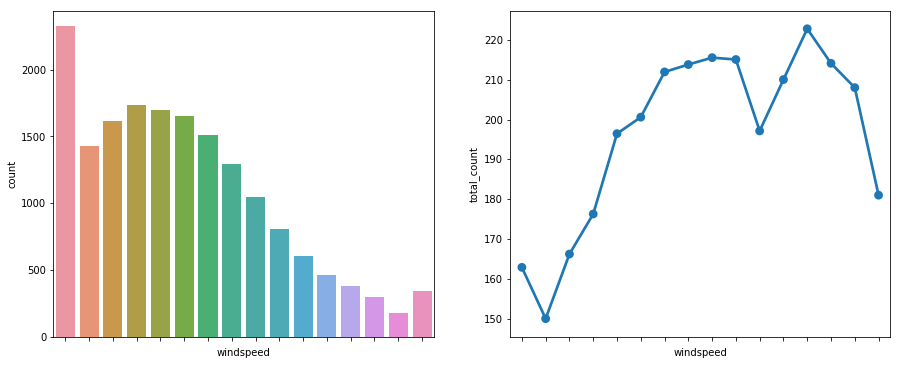

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(hour['windspeed'].compute(), ax=ax1)
sns.pointplot(x="windspeed", y="total_count", data=hour.compute(), ci=False, ax=ax2)
ax1.set_xticklabels([])
ax2.set_xticklabels([])

### Other Outliers<a class="anchor" id="5.2.2"></a>

Something that we should note is that in October 2012, there is a huge drop in the quantity of bikes rented at the end of the month. As we can see in the graph below, `total_count` drops to 0 on a particular day (October 29).

After some research we concluded that this is not an error in the data, but since was updated in real time with no filters, we found out that that particular day Washington D.C. was hit by Hurricane Sandy and therefore the rentals droped to zero.

_Source: https://www.telegraph.co.uk/news/worldnews/northamerica/usa/9642980/Hurricane-Sandy-October-29-as-it-happened.html_

In [50]:
aug_2012 = day[(day['year'] == "2012") & (day['month'] == "august")]
sep_2012 = day[(day['year'] == "2012") & (day['month'] == "september")]
oct_2012 = day[(day['year'] == "2012") & (day['month'] == "october")]
nov_2012 = day[(day['year'] == "2012") & (day['month'] == "november")]

day_30 = da.arange(1, 31)
day_31 = da.arange(1, 32)

Text(23.5, 210, 'Hurricane Sandy -->')

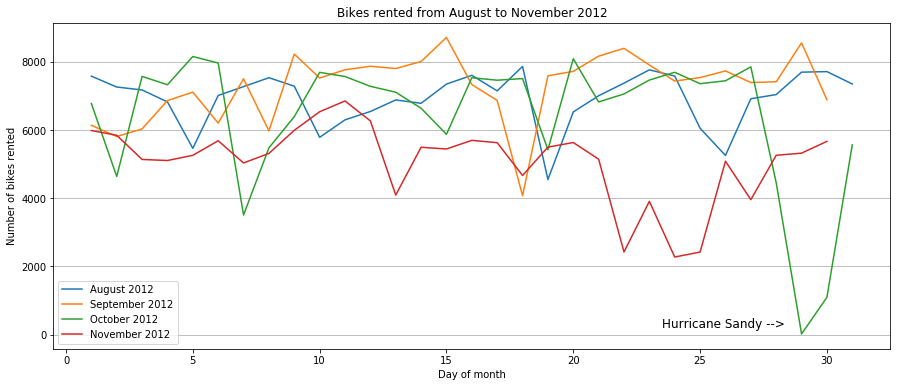

In [51]:
plt.subplots(figsize=(15, 6))
sns.lineplot(x=day_31.compute(), y="total_count", data=aug_2012.compute())
sns.lineplot(x=day_30.compute(), y="total_count", data=sep_2012.compute())
sns.lineplot(x=day_31.compute(), y="total_count", data=oct_2012.compute())
sns.lineplot(x=day_30.compute(), y="total_count", data=nov_2012.compute())
plt.legend(labels=["August 2012", "September 2012", "October 2012", "November 2012"])
plt.xlabel("Day of month")
plt.ylabel("Number of bikes rented")
plt.title("Bikes rented from August to November 2012")
plt.grid(axis="y")
plt.text(23.5, 210, "Hurricane Sandy -->", color="black", size=12)

This might not affect our results in a significant way, but since this event is non recurring and will not repeat in the future in a predicted way, we consider this to be an outlier. We will proceed to impute it with the mean for that specific month later on.

In [52]:
sept_annual_increase = (
    day['total_count'][(day['month'] == "september") & (day['year'] == "2012")].mean()
    / day['total_count'][(day['month'] == "september") & (day['year'] == "2011")].mean()
)

For this imputation we first computed the mean increase in September, considering it is the most similar to October. Then we took the previous year's values and added the increment to them.

In [53]:
total_count_increase = (
    hour["total_count"][
        hour["datetime"].isin(["2011-10-28", "2011-10-29", "2011-10-30"])
    ].mean()
    * sept_annual_increase
)

total_count = dd.from_dask_array(da.zeros((shape[0], 1)), columns=['total_count'], index=hour.index)

condition_hurricane_change = (hour["datetime"].isin(["2011-10-28", "2011-10-29", "2011-10-30"]))
condition_hurricane_leave = (hour["datetime"].notnull())

total_count['total_count'] = total_count['total_count'].mask(condition_hurricane_leave, hour['total_count'])
total_count['total_count'] = total_count['total_count'].mask(condition_hurricane_change, total_count_increase)

hour['total_count'] = total_count['total_count']

In [54]:
registered_increase = (
    hour["registered"][
        hour["datetime"].isin(["2011-10-28", "2011-10-29", "2011-10-30"])
    ].mean()
    * sept_annual_increase
)

registered = dd.from_dask_array(da.zeros((shape[0], 1)), columns=['registered'], index=hour.index)

condition_hurricane_change = (hour["datetime"].isin(["2011-10-28", "2011-10-29", "2011-10-30"]))
condition_hurricane_leave = (hour["datetime"].notnull())

registered['registered'] = registered['registered'].mask(condition_hurricane_leave, hour['total_count'])
registered['registered'] = registered['registered'].mask(condition_hurricane_change, total_count_increase)

hour['registered'] = registered['registered']

In [55]:
casual_increase = (
    hour["casual"][
        hour["datetime"].isin(["2011-10-28", "2011-10-29", "2011-10-30"])
    ].mean()
    * sept_annual_increase
)

casual = dd.from_dask_array(da.zeros((shape[0], 1)), columns=['casual'], index=hour.index)

condition_hurricane_change = (hour["datetime"].isin(["2011-10-28", "2011-10-29", "2011-10-30"]))
condition_hurricane_leave = (hour["datetime"].notnull())

casual['casual'] = casual['casual'].mask(condition_hurricane_leave, hour['casual'])
casual['casual'] = casual['casual'].mask(condition_hurricane_change, casual_increase)

hour['casual'] = casual['casual']

## Droping Variables<a class="anchor" id="5.3"></a>

We decided to drop the columns `casual` and `registered` since we are only interested in the `total_count` and they are so correlated that can cause overfitting.

`temp` is also extremely correlated with `atemp`, but since we believe `atemp` has much more effect on the target variable, we decided to keep that one.

**Update: we get better scores with `temp` so we will leave it.


Besides having `temp` embedded, `atemp` also comprises `humidity` and `windspeed`, but since they are not as correlated in the matrix we decided to leave them.

><font size=2, color=black>_Apparent temperature is the temperature equivalent perceived by humans, caused by the combined effects of air temperature, relative humidity and wind speed. The measure is most commonly applied to the perceived outdoor temperature._</font>

We expect that the vatiables `average_activity` and `is_commute` created above will emprise all the information conveyed in `hour`, but since scores are higher with it we decided to leave it.


We will also drop all variables used to compute our `atemp_comp` variable.

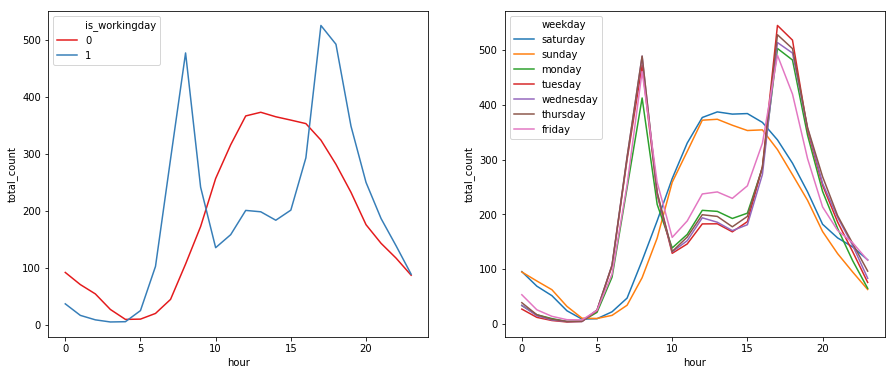

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.lineplot(
    x="hour",
    y="total_count",
    hue="is_workingday",
    data=hour.compute(),
    ci=None,
    palette="Set1",
    ax=ax1,
)

sns.lineplot(x="hour", y="total_count", hue="weekday", data=hour.compute(), ci=None, ax=ax2)

In [57]:
hour.columns

Index(['datetime', 'season', 'year', 'month', 'hour', 'is_holiday', 'weekday',
       'is_workingday', 'weather_condition', 'temp', 'atemp', 'humidity',
       'windspeed', 'casual', 'registered', 'total_count', 'average_activity',
       'is_commute'],
      dtype='object')

In [58]:
hour = hour.drop(['casual', 'registered'], axis=1)